In [1]:
#1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import warnings

from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')



# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("talk")

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
#2
header_row = None
with open('data/WEATH.csv', 'r') as f:
    for i, line in enumerate(f):
        if line.startswith('From Date'):
            header_row = i
            break
if header_row is None: header_row = 16 # Fallback default

# 2. Load data with specific NA handling
na_values = ['None', 'NA', '-', 'nan', '', ' ']
df = pd.read_csv('data/WEATH.csv', header=header_row, parse_dates=['From Date'], dayfirst=True, na_values=na_values)

# 3. Cleaning
# Set index to Datetime and sorting
df['Datetime'] = pd.to_datetime(df['From Date'], errors='coerce')
df = df.sort_values('Datetime').set_index('Datetime')
df = df[df.index.notna()] # Drop metadata footer rows

# Drop completely empty columns 
df = df.dropna(axis=1, how='all')

# Convert remaining columns to numeric, coercing errors to NaN
for col in df.columns:
    if col not in ['From Date', 'To Date']:
         df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute small missing gaps (forward fill first, then backwards fill)
df = df.ffill().bfill()

print("Data loaded and cleaned.")
print(f"Date Range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Total Records: {len(df)}")

Data loaded and cleaned.
Date Range: 2024-01-03 to 2025-09-30
Total Records: 637


In [3]:
#3  
#--- AQI Calculation ---
breakpoints = {
    'PM2.5': [(0, 30), (31, 60), (61, 90), (91, 120), (121, 250), (250, 400)],
    'PM10':  [(0, 50), (51, 100), (101, 250), (251, 350), (351, 430), (430, 500)],
    'NO2':   [(0, 40), (41, 80), (81, 180), (181, 280), (281, 400), (400, 500)]
}
aqi_ranges = [(0, 50), (51, 100), (101, 200), (201, 300), (301, 400), (401, 500)]

def get_sub_index(conc, pollutant):
    if pollutant not in breakpoints or pd.isna(conc): return 0
    for i, (low, high) in enumerate(breakpoints[pollutant]):
        if low <= conc <= high:
            alow, ahigh = aqi_ranges[i]
            return alow + (ahigh - alow) * (conc - low) / (high - low)
    if conc > breakpoints[pollutant][-1][1]: return 500
    return 0

# Calculate sub-indices and final AQI
for pol in breakpoints.keys():
    if pol in df.columns:
        df[f'{pol}_SubIndex'] = df.apply(lambda x: get_sub_index(x[pol], pol), axis=1)

sub_idx_cols = [c for c in df.columns if '_SubIndex' in c]
df['AQI_Calculated'] = df[sub_idx_cols].max(axis=1)

# Filter out invalid AQI rows (rare, but possible if all pollutants missing)
df = df[df['AQI_Calculated'] > 0].copy()

print("AQI Calculated.")
print(df[['PM2.5', 'PM10', 'AQI_Calculated']].head())

AQI Calculated.
            PM2.5   PM10  AQI_Calculated
Datetime                                
2024-01-03  55.75  91.74       92.818966
2024-01-04  60.64  97.47       97.470000
2024-01-05  43.57  72.25       72.250000
2024-01-06  38.88  69.54       69.540000
2024-01-07  31.91  59.56       59.560000


In [4]:
# 4
#--- Feature Engineering ---
# 1. Time Features
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek

# 2. Lag Features (Past values)
features_to_lag = ['AQI_Calculated', 'PM2.5', 'PM10', 'NO2', 'WS', 'RH', 'Temp']
for col in features_to_lag:
    if col in df.columns:
        for lag in [1, 2, 3, 7]:
             df[f'{col}_lag_{lag}d'] = df[col].shift(lag)

# 3. Rolling Features (Trends)
# Shift by 1 to avoid data leakage (using only PAST data)
df['AQI_roll_mean_3d'] = df['AQI_Calculated'].shift(1).rolling(3).mean()
df['AQI_roll_mean_7d'] = df['AQI_Calculated'].shift(1).rolling(7).mean()

print("Features created.")

Features created.


In [5]:
#5 
#--- Target Creation & Splitting ---
TARGET = 'AQI_Calculated'
FORECAST_HORIZON = 1

# 1. Target
df['y_target'] = df[TARGET].shift(-FORECAST_HORIZON)
df_final = df.dropna()

# 2. Separate Features (X) and Target (y)
X = df_final.select_dtypes(include=['number'])
drop_cols = ['y_target', TARGET] + [c for c in X.columns if '_SubIndex' in c]
X = X.drop(columns=drop_cols, errors='ignore')
y = df_final['y_target']

# 3. Chronological Split (80% Train, 20% Test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 503
Testing samples: 126


In [6]:
#6
# --- Baseline Model ---
# Predicts "Tomorrow will be the same as Today"
y_pred_baseline = X_test['AQI_Calculated_lag_1d']

base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
base_mae = mean_absolute_error(y_test, y_pred_baseline)

print(f"Baseline (Persistence) RMSE: {base_rmse:.2f}")
print(f"Baseline (Persistence) MAE:  {base_mae:.2f}")

Baseline (Persistence) RMSE: 12.18
Baseline (Persistence) MAE:  7.88


Re-training standalone XGBoost for demonstration...


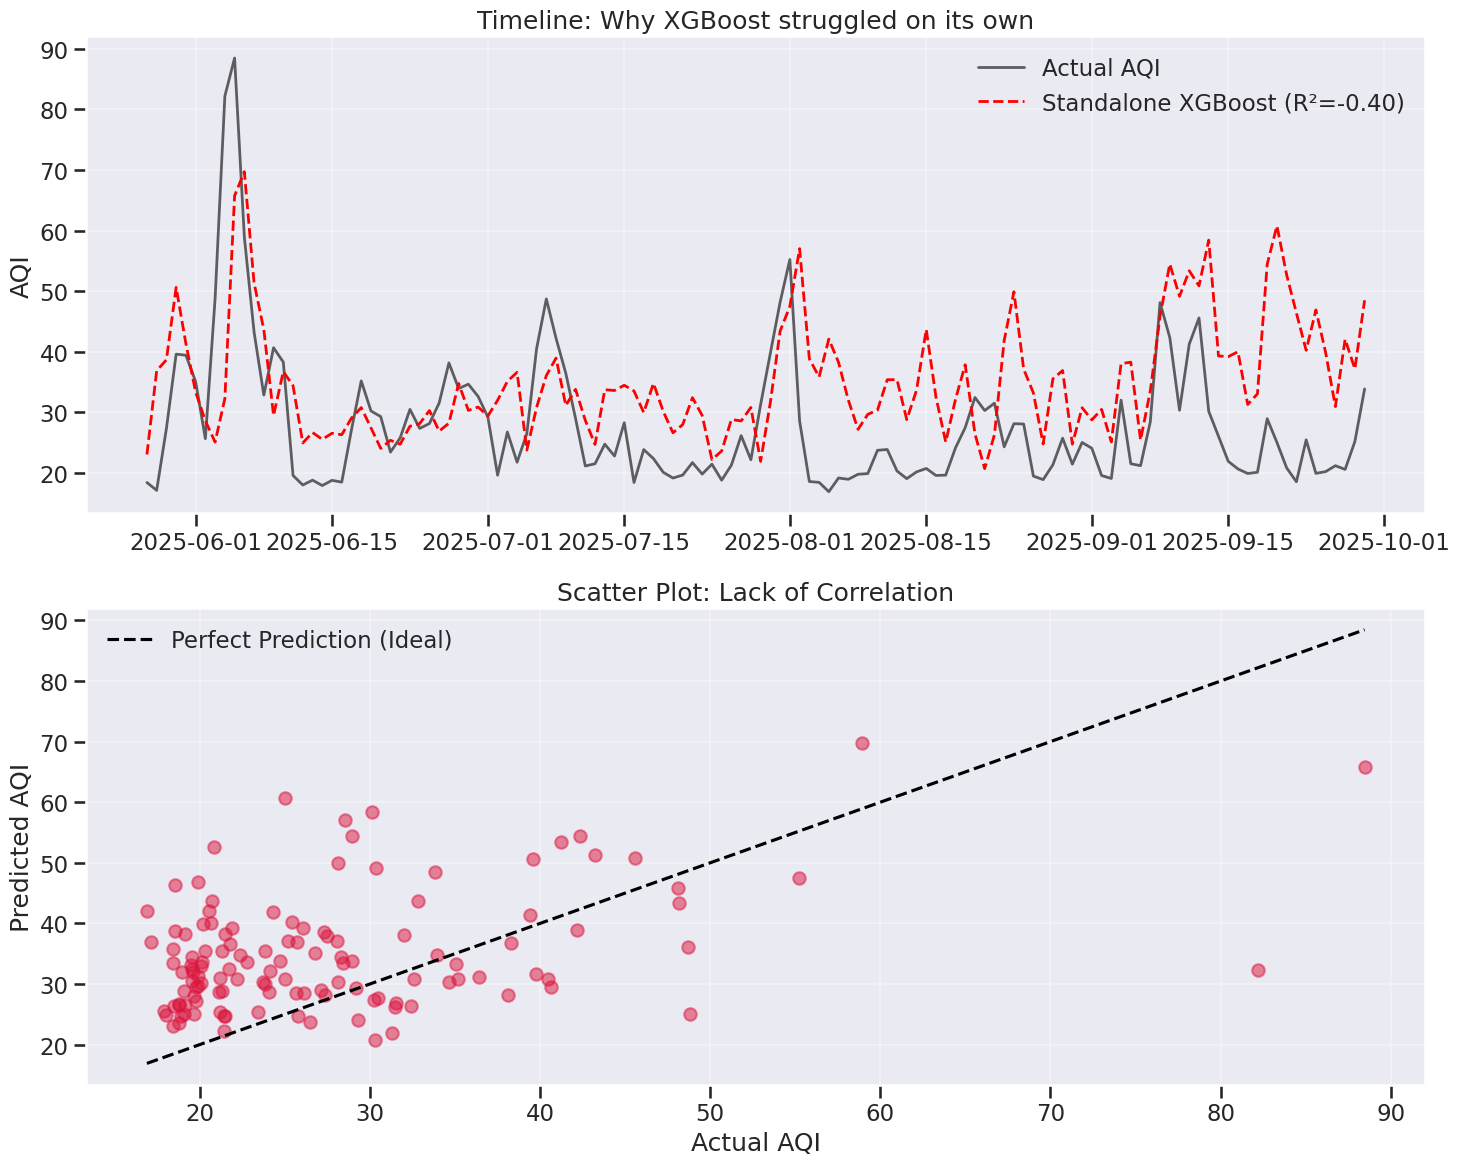

In [7]:
#7
# --- 1. Re-train Standalone XGBoost (for visualization purposes) ---
# We use the same features as the final model for a fair comparison,
# but without the linear baseline helper.
print("Re-training standalone XGBoost for demonstration...")
xgb_standalone = xgb.XGBRegressor(n_estimators=500, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb_standalone.fit(X_train, y_train, verbose=False)
y_pred_standalone = xgb_standalone.predict(X_test)

# Calculate its specific metrics
rmse_standalone = np.sqrt(mean_squared_error(y_test, y_pred_standalone))
r2_standalone = r2_score(y_test, y_pred_standalone)

# --- 2. Create Diagnostic Plots ---
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# PLOT 1: Timeline Comparison
# Shows how it fails to capture peaks and troughs accurately
axes[0].plot(y_test.index, y_test, label='Actual AQI', color='black', alpha=0.6, linewidth=2)
axes[0].plot(y_test.index, y_pred_standalone, label=f'Standalone XGBoost (R²={r2_standalone:.2f})', color='red', linestyle='--', linewidth=2)
axes[0].set_title('Timeline: Why XGBoost struggled on its own')
axes[0].set_ylabel('AQI')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PLOT 2: Actual vs Predicted Scatter
# A good model should look like a straight diagonal line.
# A bad model looks like a randomly scattered cloud.
axes[1].scatter(y_test, y_pred_standalone, alpha=0.5, color='crimson')
# Add a perfect prediction line (y=x) for reference
min_val, max_val = min(y_test.min(), y_pred_standalone.min()), max(y_test.max(), y_pred_standalone.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (Ideal)')
axes[1].set_title('Scatter Plot: Lack of Correlation')
axes[1].set_xlabel('Actual AQI')
axes[1].set_ylabel('Predicted AQI')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# 8 
#--- Hybrid Model Training ---

# 1. Prepare Data for Hybrid approach
# Base model gets ONLY yesterday's AQI
X_base_train = X_train[['AQI_Calculated_lag_1d']]
X_base_test = X_test[['AQI_Calculated_lag_1d']]
# Residual model gets everything ELSE
X_resid_train = X_train.drop(columns=['AQI_Calculated_lag_1d'])
X_resid_test = X_test.drop(columns=['AQI_Calculated_lag_1d'])

# 2. Train Base Model (Linear Regression)
print("Training Base Model...")
lr_model = LinearRegression()
lr_model.fit(X_base_train, y_train)
base_train_pred = lr_model.predict(X_base_train)
base_test_pred = lr_model.predict(X_base_test)

# 3. Calculate Residuals (Errors of Base Model)
train_residuals = y_train - base_train_pred
test_residuals = y_test - base_test_pred

# 4. Train Residual Model (XGBoost)
print("Training Residual Booster...")
xgb_resid = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.03, max_depth=4,
    subsample=0.7, colsample_bytree=0.7, early_stopping_rounds=50,
    random_state=42, n_jobs=-1
)
xgb_resid.fit(X_resid_train, train_residuals,
              eval_set=[(X_resid_test, test_residuals)], verbose=False)

# 5. Combine Predictions
final_pred = base_test_pred + xgb_resid.predict(X_resid_test)
print("Hybrid training complete.")

Training Base Model...
Training Residual Booster...
Hybrid training complete.



--- Hybrid Model Performance ---
RMSE: 12.97 (Baseline: 12.18)
MAE:  10.60  (Baseline: 7.88)
R²:   -0.30


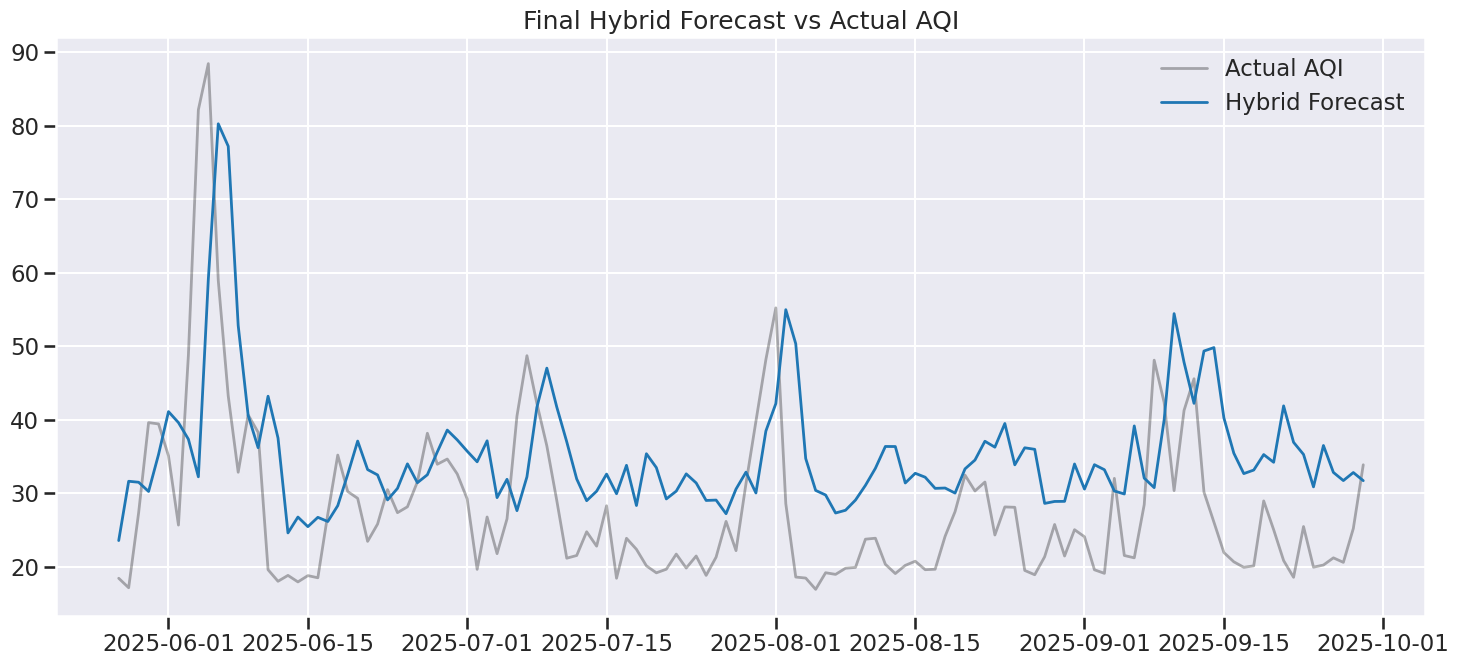

In [9]:
# 9 
#--- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
mae = mean_absolute_error(y_test, final_pred)
r2 = r2_score(y_test, final_pred)

print(f"\n--- Hybrid Model Performance ---")
print(f"RMSE: {rmse:.2f} (Baseline: {base_rmse:.2f})")
print(f"MAE:  {mae:.2f}  (Baseline: {base_mae:.2f})")
print(f"R²:   {r2:.2f}")

# Visualization
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual AQI', color='black', alpha=0.3, linewidth=2)
plt.plot(y_test.index, final_pred, label='Hybrid Forecast', color='#1f77b4', linewidth=2)
plt.title('Final Hybrid Forecast vs Actual AQI')
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 10
#--- Time-Series Cross-Validation ---
print("Running 5-Fold Time-Series Cross-Validation...")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for train_idx, test_idx in tscv.split(X):
    # Split for this fold
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # Hybrid Training (Simplified for loop)
    lr = LinearRegression()
    lr.fit(X_tr[['AQI_Calculated_lag_1d']], y_tr)
    base_pred = lr.predict(X_te[['AQI_Calculated_lag_1d']])

    xgb_res = xgb.XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.05, n_jobs=-1, random_state=42)
    xgb_res.fit(X_tr.drop(columns=['AQI_Calculated_lag_1d']), y_tr - lr.predict(X_tr[['AQI_Calculated_lag_1d']]))

    # Fold Prediction & Score
    fold_pred = base_pred + xgb_res.predict(X_te.drop(columns=['AQI_Calculated_lag_1d']))
    cv_scores.append(np.sqrt(mean_squared_error(y_te, fold_pred)))

print(f"\nAverage CV RMSE: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

Running 5-Fold Time-Series Cross-Validation...

Average CV RMSE: 25.01 ± 7.92


In [11]:
#11
#  Final Accuracy Report ---

# 1. Calculate standard error metrics
# (Assuming 'y_test' and 'final_pred' exist from Cell 8)
mae = mean_absolute_error(y_test, final_pred)
mape = np.mean(np.abs((y_test - final_pred) / (y_test + 1e-10))) * 100
accuracy_overall = 100 - mape

# 2. Calculate "Practical Accuracy"
# We define a correct prediction as being within +/- 15 AQI points of the actual value.
# (You can adjust this threshold based on your needs)
TOLERANCE = 15
correct_predictions = np.abs(y_test - final_pred) <= TOLERANCE
accuracy_practical = np.mean(correct_predictions) * 100

# 3. Print Report
print("="*40)
print("MODEL ACCURACY REPORT")
print("="*40)
print(f"Mean Absolute Error (MAE): {mae:.2f} AQI points")
print(f"Mean Percentage Error (MAPE): {mape:.2f}%")
print("-" * 40)
print(f"Overall Model Accuracy (100% - MAPE): {accuracy_overall:.2f}%")
print(f"Practical Accuracy (within ±{TOLERANCE} AQI): {accuracy_practical:.2f}%")
print("="*40)

# 4. (Optional) Show best and worst predictions
results = pd.DataFrame({'Actual': y_test, 'Predicted': final_pred})
results['Error'] = np.abs(results['Actual'] - results['Predicted'])
print("\nBest 3 Predictions:\n", results.sort_values('Error').head(3))
print("\nWorst 3 Predictions:\n", results.sort_values('Error', ascending=False).head(3))

MODEL ACCURACY REPORT
Mean Absolute Error (MAE): 10.60 AQI points
Mean Percentage Error (MAPE): 42.69%
----------------------------------------
Overall Model Accuracy (100% - MAPE): 57.31%
Practical Accuracy (within ±15 AQI): 79.37%

Best 3 Predictions:
             Actual  Predicted     Error
Datetime                               
2025-06-09   40.66  40.588430  0.071570
2025-06-26   31.54  31.417882  0.122118
2025-07-08   42.20  41.682100  0.517900

Worst 3 Predictions:
             Actual  Predicted      Error
Datetime                                
2025-06-04  82.180  32.220297  49.959703
2025-06-07  43.230  77.220559  33.990559
2025-08-03  18.575  50.332604  31.757604


Initializing Committee of Models...
Training Stacking Ensemble...

--- Stacking Ensemble Performance ---
RMSE: 9.60
MAE:  7.88
R²:   0.29


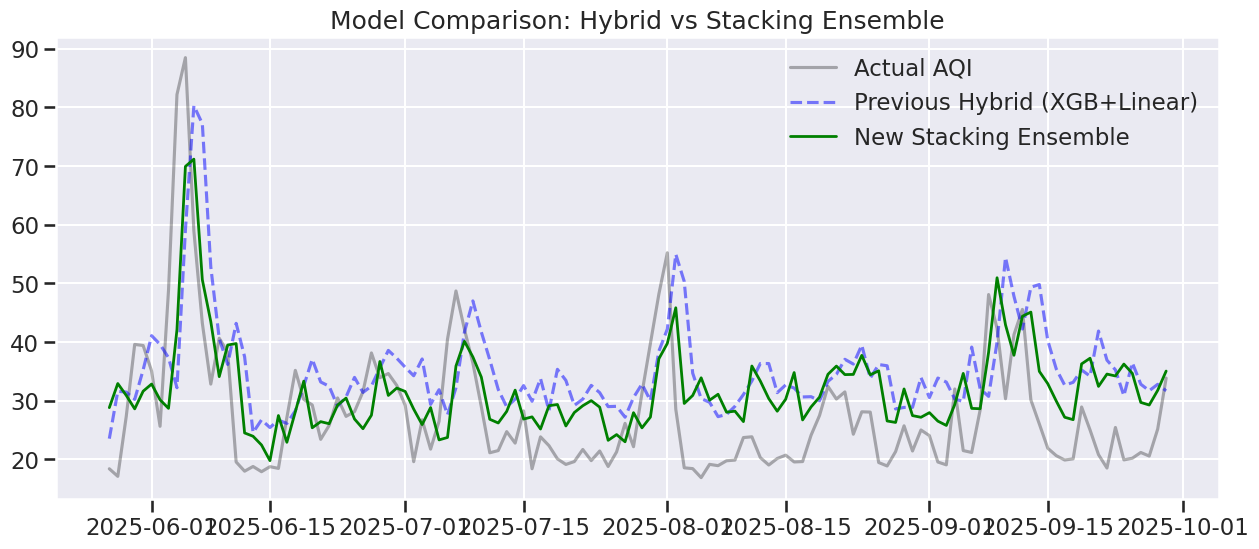

In [12]:
#12

# Advanced Stacking Ensemble ---

print("Initializing Committee of Models...")

# 1. Define the "Experts" (Base Models)
# SVR needs scaled data, so we use a pipeline for it
svr_pipe = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1))

estimators = [
    ('ridge', Ridge(random_state=42)),
    ('rf',    RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)),
    ('svr',   svr_pipe),
    ('xgb',   xgb.XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1))
]

# 2. Define the "Committee Head" (Meta-Learner)
# It will learn how much to trust each expert.
final_estimator = LinearRegression()

# 3. Build the Stacking Regressor
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1,
    passthrough=False # False = Meta-model only sees the predictions of base models, not original features
)

# 4. Train the entire stack
print("Training Stacking Ensemble...")
stacking_model.fit(X_train, y_train)

# 5. Evaluate
stack_pred = stacking_model.predict(X_test)

# Calculate Metrics
stack_rmse = np.sqrt(mean_squared_error(y_test, stack_pred))
stack_mae = mean_absolute_error(y_test, stack_pred)
stack_r2 = r2_score(y_test, stack_pred)

print(f"\n--- Stacking Ensemble Performance ---")
print(f"RMSE: {stack_rmse:.2f}")
print(f"MAE:  {stack_mae:.2f}")
print(f"R²:   {stack_r2:.2f}")

# 6. Visualise: Compare Ensemble vs Best Single Model
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual AQI', color='black', alpha=0.3)
plt.plot(y_test.index, final_pred, label='Previous Hybrid (XGB+Linear)', color='blue', linestyle='--', alpha=0.5)
plt.plot(y_test.index, stack_pred, label='New Stacking Ensemble', color='green', linewidth=2)
plt.title('Model Comparison: Hybrid vs Stacking Ensemble')
plt.legend()
plt.show()

In [13]:
#13
#Accuracy of stacking ensemble

# --- Cell 13: Final Accuracy Report (Stacking Ensemble) ---

# 1. Get Predictions on Test Set (if not already available)
# We use the stacking model as it was your best performer
test_predictions = stacking_model.predict(X_test)

# 2. Calculate Overall Accuracy (100% - Mean Percentage Error)
# We add a tiny value (1e-10) to y_test to avoid division-by-zero errors
mape = np.mean(np.abs((y_test - test_predictions) / (y_test + 1e-10))) * 100
overall_accuracy = 100 - mape

# 3. Calculate Practical Accuracy
# "What % of forecasts were close enough to be useful to the public?"
# We'll define "close enough" as being within +/- 20 AQI points of the actual value.
TOLERANCE = 20
correct_forecasts = np.abs(y_test - test_predictions) <= TOLERANCE
practical_accuracy = np.mean(correct_forecasts) * 100

# 4. Print Summary Report
print("=" * 50)
print("FINAL MODEL ACCURACY REPORT (Stacking Ensemble)")
print("=" * 50)
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, test_predictions):.2f} AQI points")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("-" * 50)
print(f"Overall Model Accuracy:    {overall_accuracy:.2f}%")
print(f"Practical Accuracy (±{TOLERANCE}): {practical_accuracy:.2f}%")
print("=" * 50)

FINAL MODEL ACCURACY REPORT (Stacking Ensemble)
Mean Absolute Error (MAE): 7.88 AQI points
Mean Absolute Percentage Error (MAPE): 31.33%
--------------------------------------------------
Overall Model Accuracy:    68.67%
Practical Accuracy (±20): 97.62%


In [14]:
#14
#Real-World Forecast for "Tomorrow" 

print("Generating forecast for the next day...")

# 1. Identify the latest available data point
# This is the last row of your original 'df', which we couldn't use for training
# because it didn't have a "tomorrow" to verify against yet.
latest_record = df.iloc[[-1]]
formatted_date = latest_record.index[0].strftime('%Y-%m-%d')

print(f"Latest data found for date: {formatted_date}")
print(f"Actual AQI on this date: {latest_record['AQI_Calculated'].values[0]:.0f}")

# 2. Prepare features for this specific day
# We must ensure it has EXACTLY the same columns the model was trained on
required_features = X_train.columns
latest_features = latest_record[required_features]

# 3. Make the Prediction using the Stacking Ensemble
future_pred = stacking_model.predict(latest_features)

print("\n" + "="*40)
print(f"OFFICIAL FORECAST FOR {formatted_date} + 1 DAY")
print("="*40)
print(f"Predicted AQI: {future_pred[0]:.1f}")

# Provide context based on standard AQI categories
def get_aqi_category(aqi):
    if aqi <= 50: return "Good 🟢"
    elif aqi <= 100: return "Satisfactory 😊"
    elif aqi <= 200: return "Moderate 😐"
    elif aqi <= 300: return "Poor 😷"
    elif aqi <= 400: return "Very Poor ☠️"
    else: return "Severe 🚨"

category = get_aqi_category(future_pred[0])
print(f"Expected Category: {category}")
print("="*40)

Generating forecast for the next day...
Latest data found for date: 2025-09-30
Actual AQI on this date: 34

OFFICIAL FORECAST FOR 2025-09-30 + 1 DAY
Predicted AQI: 36.8
Expected Category: Good 🟢


In [15]:
#15
# --- Long-Term Forecasts (Direct Strategy) ---

horizons = [7, 30] # 1 week, 1 month
latest_data = df.iloc[[-5]] # The last day we have data for
start_date = latest_data.index[0]

# Get the ACTUAL AQI on the last day for context
current_aqi = latest_data['AQI_Calculated'].values[0]

print(f"Generating long-term forecasts from base date: {start_date.date()}")
print(f"Actual AQI on this date was: {current_aqi:.1f}\n")

for h in horizons:
    print(f"--- Training {h}-Day Horizon Model ---")
    # 1. Create a specific target for this horizon
    df_h = df.copy()
    df_h['y_target_h'] = df_h['AQI_Calculated'].shift(-h)
    df_h = df_h.dropna()

    # 2. Prepare Features
    X_h = df_h.select_dtypes(include=['number'])
    drop_cols_h = ['y_target', 'y_target_h', 'AQI_Calculated'] + [c for c in X_h.columns if '_SubIndex' in c]
    X_h = X_h.drop(columns=drop_cols_h, errors='ignore')
    y_h = df_h['y_target_h']

    # 3. Train/Test Split
    split_h = int(len(X_h) * 0.8)
    X_tr_h, X_te_h = X_h.iloc[:split_h], X_h.iloc[split_h:]
    y_tr_h, y_te_h = y_h.iloc[:split_h], y_h.iloc[split_h:]

    # 4. Train Model
    model_h = xgb.XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.03, random_state=42, n_jobs=-1)
    model_h.fit(X_tr_h, y_tr_h, verbose=False)

    # 5. Evaluate
    y_pred_h = model_h.predict(X_te_h)
    mae_h = mean_absolute_error(y_te_h, y_pred_h)
    print(f"Model Accuracy (MAE) for +{h} days: +/- {mae_h:.2f} AQI points")

    # 6. Generate Forecast
    future_features = latest_data[X_h.columns]
    future_forecast = model_h.predict(future_features)[0]
    forecast_date = start_date + pd.Timedelta(days=h)

    # PRINTING BOTH VALUES NOW
    print(f">>> FORECAST for {forecast_date.date()} (+{h} days): {future_forecast:.1f} AQI")
    print(f"    (Change from today: {future_forecast - current_aqi:+.1f} points)\n")

Generating long-term forecasts from base date: 2025-09-26
Actual AQI on this date was: 20.2

--- Training 7-Day Horizon Model ---
Model Accuracy (MAE) for +7 days: +/- 21.59 AQI points
>>> FORECAST for 2025-10-03 (+7 days): 28.9 AQI
    (Change from today: +8.7 points)

--- Training 30-Day Horizon Model ---
Model Accuracy (MAE) for +30 days: +/- 18.58 AQI points
>>> FORECAST for 2025-10-26 (+30 days): 68.7 AQI
    (Change from today: +48.5 points)



In [16]:
import joblib
import os


model_filename = 'bangalore_aqi_stacking_model.pkl'

print(f"Saving model to {model_filename}...")
joblib.dump(stacking_model, model_filename)

if os.path.exists(model_filename):
    size_kb = os.path.getsize(model_filename)/ 1024
    print(f"Success! Model saved. File size: {size_kb:.2f} KB")
else:
    print("Error: Model file not found after saving.")

# --- 2. (Optional) How to Load and Use it Later ---
# This part is just for demonstration. In a real app, you'd run this in a new file.
print("\n--- Demonstration: Loading model for a new prediction ---")

# Load the model from the file
loaded_model = joblib.load(model_filename)
print("Model loaded successfully.")

# Create a dummy example of "today's data" to predict "tomorrow"
# We'll just use the last row of your test set as an example
sample_data = X_test.iloc[[-1]]

# Make a prediction using the LOADED model
prediction = loaded_model.predict(sample_data)
print(f"Predicted AQI for the next day (using loaded model): {prediction[0]:.1f}")

Saving model to bangalore_aqi_stacking_model.pkl...
Success! Model saved. File size: 1294.17 KB

--- Demonstration: Loading model for a new prediction ---
Model loaded successfully.
Predicted AQI for the next day (using loaded model): 35.1
